In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121, ResNet50, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Concatenate, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Enable Mixed Precision for faster computation
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Enable XLA (Accelerated Linear Algebra) for TensorFlow optimization
tf.config.optimizer.set_jit(True)

# 1. Load and Preprocess the Dataset
def load_ekush_data(dataset_path):
    class_names = sorted(os.listdir(dataset_path))  # Compound character classes
    images, labels = [], []

    for label, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = tf.keras.utils.load_img(img_path, target_size=(64, 64), color_mode='rgb')
            img = tf.keras.utils.img_to_array(img) / 255.0
            images.append(img)
            labels.append(label)

    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32), class_names

dataset_path = "/content/drive/MyDrive/Dataset/Dataset_5k/Dataset_5k"
images, labels, class_names = load_ekush_data(dataset_path)
print(f"Dataset loaded: {len(images)} images and {len(class_names)} classes.")

Dataset loaded: 5030 images and 50 classes.


In [ ]:
# 2. Split Dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Convert dataset to TensorFlow Dataset format for faster loading
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(len(X_train))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [ ]:
# 3. Build Ensemble Model
input_layer = Input(shape=(64, 64, 3))

# Load Pretrained Models
# Remove input_tensor argument and create separate input layers for each model
base_model_1 = DenseNet121(weights="imagenet", include_top=False)
base_model_2 = ResNet50(weights="imagenet", include_top=False)
base_model_3 = VGG19(weights="imagenet", include_top=False)

# Freeze Initial Layers
for model in [base_model_1, base_model_2, base_model_3]:
    for layer in model.layers[:]:
        layer.trainable = False

# Extract Features
# Pass the input_layer to each base model separately
x1 = GlobalAveragePooling2D()(base_model_1(input_layer))
x2 = GlobalAveragePooling2D()(base_model_2(input_layer))
x3 = GlobalAveragePooling2D()(base_model_3(input_layer))

# Concatenate Features
merged = Concatenate()([x1, x2, x3])
merged = BatchNormalization()(merged)
merged = Dropout(0.5)(merged)
merged = Dense(512, activation="relu")(merged)
merged = BatchNormalization()(merged)
output = Dense(len(class_names), activation="softmax", dtype="float32")(merged)

# Define Model
model = Model(inputs=input_layer, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet121 (Functional)  │ (None, 2, 2, 1024)     │      7,037,504 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 2, 2, 2048)     │     23,587,712 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg19 (Functional)        │ (None, 2, 2, 512)      │     20,024,384 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ densenet121[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ vgg19[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 3584)           │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 3584)           │         14,336 │ concatenate_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 3584)           │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │      1,835,520 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 512)            │          2,048 │ dense_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_7 (Cast)             │ (None, 512)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 50)             │         25,650 │ cast_7[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 52,527,154 (200.38 MB)

 Trainable params: 1,869,362 (7.13 MB)

 Non-trainable params: 50,657,792 (193.24 MB)

In [ ]:
# 4. Train the Model
history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=test_dataset,
    verbose=1,
    callbacks=[lr_scheduler]
)

Epoch 1/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 709s 5s/step - accuracy: 0.2365 - loss: 3.2065 - val_accuracy: 0.5030 - val_loss: 2.1354 - learning_rate: 5.0000e-04
Epoch 2/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 665s 5s/step - accuracy: 0.6904 - loss: 1.1261 - val_accuracy: 0.6581 - val_loss: 1.4397 - learning_rate: 5.0000e-04
Epoch 3/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 649s 5s/step - accuracy: 0.7989 - loss: 0.7488 - val_accuracy: 0.7117 - val_loss: 1.1139 - learning_rate: 5.0000e-04
Epoch 4/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 663s 5s/step - accuracy: 0.8620 - loss: 0.5163 - val_accuracy: 0.7485 - val_loss: 0.9397 - learning_rate: 5.0000e-04
Epoch 5/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 664s 5s/step - accuracy: 0.9068 - loss: 0.3899 - val_accuracy: 0.7654 - val_loss: 0.8814 - learning_rate: 5.0000e-04
Epoch 6/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 682s 5s/step - accuracy: 0.9210 - loss: 0.3328 - val_accuracy: 0.7694 - val_loss: 0.8593 - learning_rate: 5.0000e-04
Epoch 7/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 697s 5s/step - acc

In [ ]:
# 5. Evaluate the Model
y_pred = np.argmax(model.predict(X_test, batch_size=BATCH_SIZE), axis=1)

# Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Classification report
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

# Save model and report
model.save("bangla_compound_character_ensemble.h5")
report_df.to_csv("ensemble_classification_report.csv")

32/32 ━━━━━━━━━━━━━━━━━━━━ 157s 5s/step


Accuracy: 0.7823
Precision: 0.7882
Recall: 0.7823
F1-score: 0.7812
              precision    recall  f1-score      support
1              0.812500  0.650000  0.722222    20.000000
10             0.592593  0.800000  0.680851    20.000000
11             0.684211  0.650000  0.666667    20.000000
12             0.777778  0.700000  0.736842    20.000000
13             0.850000  0.850000  0.850000    20.000000
14             1.000000  0.850000  0.918919    20.000000
15             0.913043  0.875000  0.893617    24.000000
16             0.882353  0.750000  0.810811    20.000000
17             0.736842  0.700000  0.717949    20.000000
18             0.809524  0.850000  0.829268    20.000000
19             0.800000  0.800000  0.800000    20.000000
2              0.695652  0.800000  0.744186    20.000000
20             0.722222  0.590909  0.650000    22.000000
21             0.833333  1.000000  0.909091    20.000000
22             0.611111  0.550000  0.578947    20.000000
23             0.8095

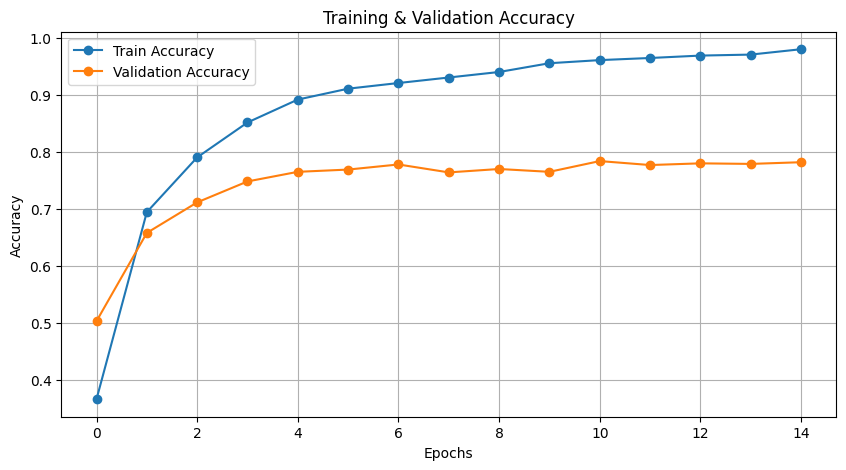

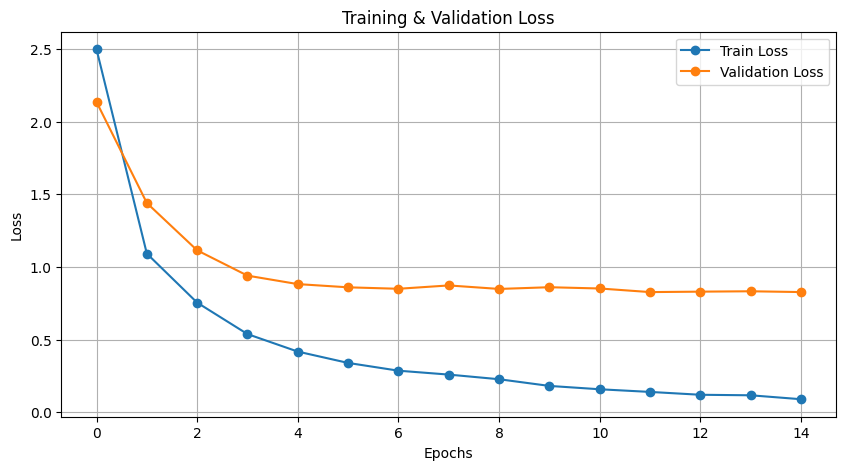

In [ ]:
# 6. Plot Training Results
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.title("Training & Validation Accuracy")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.title("Training & Validation Loss")
plt.show()

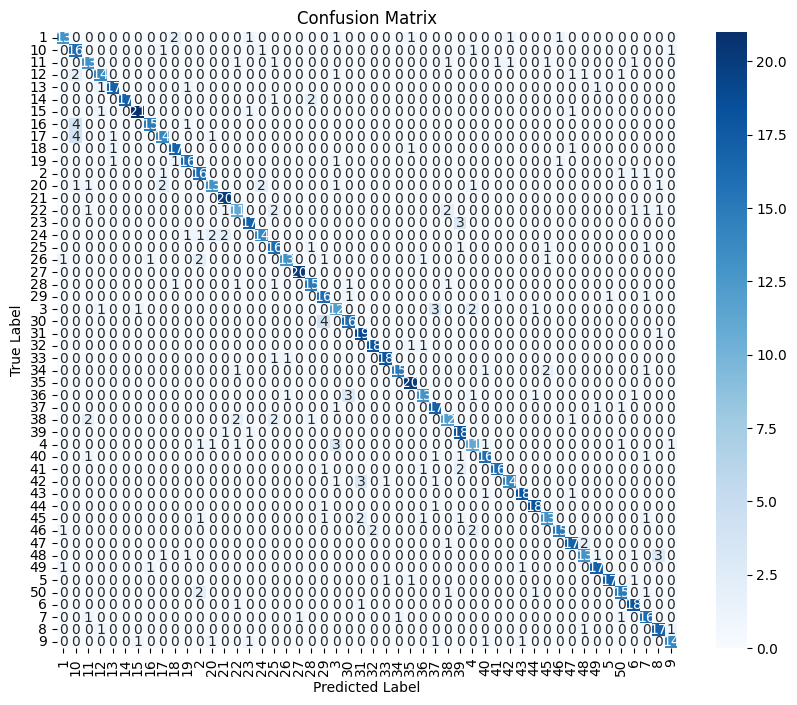

In [ ]:

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()